In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white")


In [245]:
%matplotlib inline

### Pulling the data from data.world website

In [246]:
university_ranks = pd.read_excel('https://query.data.world/s/xuvlcrw5hyvgddgtj7mhk3w2rdj37y')

In [247]:
university_ranks.head()

,name,location,rank,world_rank,description,tuition_and_fees,in_state,undergrad_enrollment,city,state
0,Princeton University,"Princeton, NJ",1,7,"Princeton, the fourth-oldest college in the Un...",45.320,NaN,5402,Princeton,NJ
1,Harvard University,"Cambridge, MA",2,6,"Harvard is located in Cambridge, Massachusetts...",47.074,NaN,6699,Cambridge,MA
2,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52.491,NaN,5844,Chicago,IL
3,Yale University,"New Haven, CT",3,12,"Yale University, located in New Haven, Connect...",49.480,NaN,5532,New Haven,CT
4,Columbia University,"New York, NY",5,15,"Columbia University, located in Manhattan's Mo...",55.056,NaN,6102,New York,NY


### Processing the data

In [248]:
university_ranks['tuition_and_fees'] = university_ranks['tuition_and_fees']*1000
university_ranks['in_state'].fillna(value = university_ranks['tuition_and_fees'],inplace =True)

In [249]:
university_ranks.head()

,name,location,rank,world_rank,description,tuition_and_fees,in_state,undergrad_enrollment,city,state
0,Princeton University,"Princeton, NJ",1,7,"Princeton, the fourth-oldest college in the Un...",45320.0,45320,5402,Princeton,NJ
1,Harvard University,"Cambridge, MA",2,6,"Harvard is located in Cambridge, Massachusetts...",47074.0,47074,6699,Cambridge,MA
2,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844,Chicago,IL
3,Yale University,"New Haven, CT",3,12,"Yale University, located in New Haven, Connect...",49480.0,49480,5532,New Haven,CT
4,Columbia University,"New York, NY",5,15,"Columbia University, located in Manhattan's Mo...",55056.0,55056,6102,New York,NY


In [250]:
university_ranks.shape

(89, 10)

In [251]:
university_ranks['undergrad_enrollment']=university_ranks['undergrad_enrollment'].astype(float)


## Scatter plot 
### The cost of attending an university decreases as its rank lowers. This is expected as high ranking colleges tend to be expensive.
### The colormap shows that universities with lower tuition have higher undergraduate enrollment. 
### The colormap also shows that high ranking colleges have smaller class and are extremely competitive due to their lower undergraduate enrollment

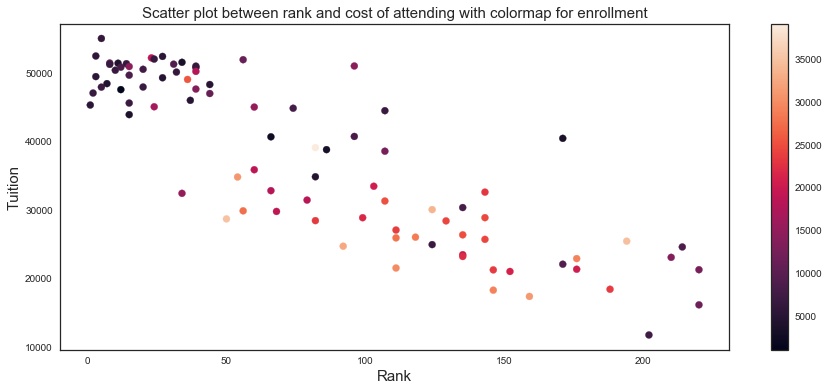

In [252]:
plt.figure(figsize=(15,6))
points = plt.scatter(university_ranks['rank'],university_ranks['tuition_and_fees'],
                      c=university_ranks['undergrad_enrollment']) #set style options
plt.colorbar(points)
plt.xlabel('Rank',fontsize = 15)
plt.ylabel('Tuition',fontsize = 15)
plt.title('Scatter plot between rank and cost of attending with colormap for enrollment',fontsize = 15)
plt.show()

In [282]:
state_wise = university_ranks['state'].value_counts().to_frame().reset_index()
state_wise.columns = ['state','universities']

uni_state = university_ranks.groupby('state')['name'].apply(lambda x: '{}'.format(',<br> '.join(x))).to_frame().reset_index()
state_wise = pd.merge(state_wise,uni_state,on = 'state',how = 'left')
state_wise['state'] = state_wise['state'].astype(str)
state_wise.head()

,state,universities,name
0,NY,8,"Columbia University,<br> Cornell University,<b..."
1,MA,7,"Harvard University,<br> Massachusetts Institut..."
2,PA,6,"University of Pennsylvania,<br> Carnegie Mello..."
3,FL,5,"University of Miami,<br> University of Florida..."
4,CA,5,"Stanford University,<br> California Institute ..."


## Distribution of top ranked colleges based on their states.
### New York and Masachusetts has highest number of schools in this list.

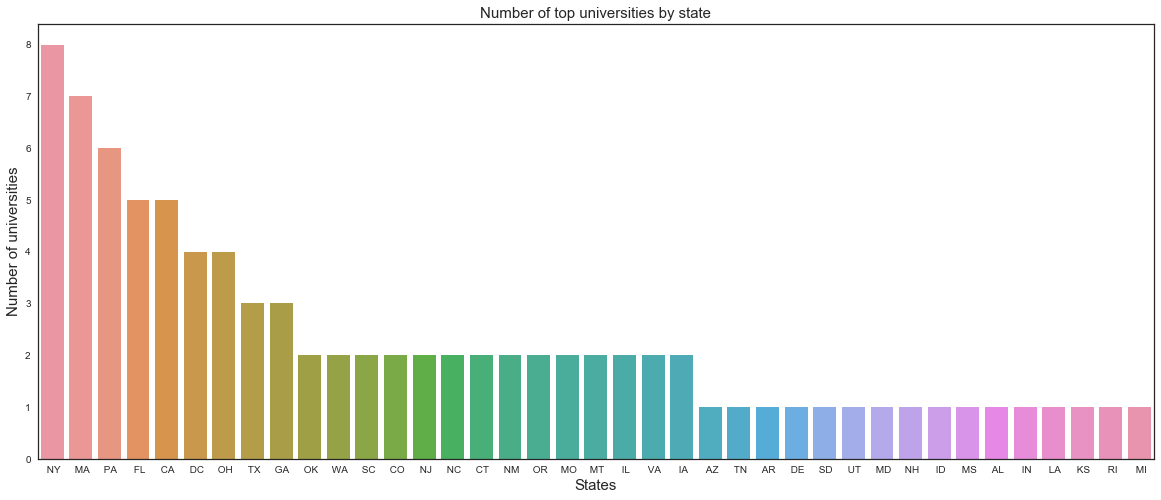

In [254]:
plt.figure(figsize=(20,8))
sns.barplot('state','universities', data = state_wise)
plt.xlabel('States',fontsize =15)
plt.ylabel('Number of universities',fontsize =15)
plt.title('Number of top universities by state',fontsize =15)
plt.show()

## Disrtibution of top univiersities on US map by states

In [294]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#py.offline.init_notebook_mode(connected=True)
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
           [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_wise['state'].astype(str),
        z = state_wise['universities'].astype(float),
        locationmode = 'USA-states',
        text = state_wise['name'],
        visible = True,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Top Universities")
        ) ]

layout = dict(
        title = 'Top University Ranking by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig,filename='d3-cloropleth-map')


## Categorize the states by regions defined by US Census Board

In [256]:
regions_of_us = {'NorthEast':['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island','Connecticut','New York','New Jersey','Pennsylvania'],
                'MidWest':['Ohio','Michigan','Indiana','Wisconsin','Illinois','Minnesota','Iowa','Missouri','North Dakota','South Dakota','Nebraska','Kansas'],
                'South':['Delaware','Maryland','Virginia','West Virginia','Kentucky','North Carolina','South Carolina','Tennessee','Georgia','Florida','Alabama','Mississippi','Arkansas','Louisiana','Texas','Oklahoma','District of Columbia'],
                'West':['Montana','Idaho','Wyoming','Colorado','New Mexico','Arizona','Utah','Nevada','California','Oregon','Washington','Alaska','Hawaii']}

In [257]:
from bs4 import BeautifulSoup
import urllib.request

## Scraping the website for state abbreviations and full names of state  
### The university ranking data has state abbreviations while regions dictionary has full names. This step is needed to merge them.

In [258]:
#r=urllib.request.urlopen("http://www.50states.com/abbreviations.htm").read()
r=urllib.request.urlopen("https://www.ups.com/worldshiphelp/WS16/ENU/AppHelp/Codes/State_Province_Codes.htm").read()

soup=BeautifulSoup(r,'lxml')
type(soup)

bs4.BeautifulSoup

In [259]:
print (soup.prettify()[:100])

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Frameset//EN">
<html>
 <head>
  <meta content="text/html


In [260]:
all_tables=soup.find_all('table')

all_tables

[<table cellspacing="0" class="whs1" width="348" x-use-null-cells="">
 <col/>
 <col/>
 <tr class="whs2" valign="top">
 <td class="whs3" width="45.52%">
 <p class="whs4">State</p></td>
 <td class="whs5" width="24.83%">
 <p class="whs6"><span style="font-size: 9pt; font-weight: bold;"><font size="1" style="font-size:9pt;"><b>Code</b></font></span></p></td></tr>
 <tr class="whs2" valign="top">
 <td class="whs3" colspan="1" rowspan="1" width="45.52%">
 <p class="BodyText" style="margin-bottom: 4PT;">Alabama, US</p></td>
 <td class="whs5" colspan="1" rowspan="1" width="24.83%">
 <p class="whs7">AL</p></td></tr>
 <tr class="whs2" valign="top">
 <td class="whs3" colspan="1" rowspan="1" width="45.52%">
 <p class="whs7">Alaska, US</p></td>
 <td class="whs5" colspan="1" rowspan="1" width="24.83%">
 <p class="whs7">AK</p></td></tr>
 <tr class="whs2" valign="top">
 <td class="whs3" colspan="1" rowspan="1" width="45.52%">
 <p class="BodyText" style="margin-bottom: 4PT;">Arizona, US</p></td>
 <td cl

In [261]:
right_table=soup.find('table',class_='whs1')

In [262]:
A=[]
B=[]
for ind,row in enumerate(right_table.find_all('p',class_=['whs7','BodyText'])):
    if ind%2 ==0:
        A.append(row.find(text=True).split(',')[0])
    else:
        B.append(row.find(text=True))

In [263]:
state_abbrv = pd.DataFrame({'state_full':A,'state':B})

### Data scraped from the website using Beautiful Soup

In [264]:
state_abbrv.head()

,state_full,state
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,Armed Forces America,AA


In [265]:
regions_of_us = {l:k for k,v in regions_of_us.items() for l in v}

In [266]:
state_abbrv['Region'] = state_abbrv['state_full'].map(regions_of_us)
state_abbrv.head()

,state_full,state,Region
0,Alabama,AL,South
1,Alaska,AK,West
2,Arizona,AZ,West
3,Arkansas,AR,South
4,Armed Forces America,AA,NaN


In [267]:
state_abbrv[state_abbrv['Region'].isnull()]

,state_full,state,Region
4,Armed Forces America,AA,NaN
5,Armed Forces Europe,AE,NaN
6,Armed Forces Pacific,AP,NaN


In [268]:
state_abbrv.dropna(axis = 0,how ='any',inplace=True)
state_abbrv['state'] = state_abbrv['state'].astype(str)
university_ranks['state'] = university_ranks['state'].astype(str)

university_ranks['state'] = university_ranks['state'].str.split(' ',expand =True)[1]
university_ranks = pd.merge(university_ranks,state_abbrv,how = 'left',on ='state')
university_ranks.head()

,name,location,rank,world_rank,description,tuition_and_fees,in_state,undergrad_enrollment,city,state,state_full,Region
0,Princeton University,"Princeton, NJ",1,7,"Princeton, the fourth-oldest college in the Un...",45320.0,45320,5402.0,Princeton,NJ,New Jersey,NorthEast
1,Harvard University,"Cambridge, MA",2,6,"Harvard is located in Cambridge, Massachusetts...",47074.0,47074,6699.0,Cambridge,MA,Massachusetts,NorthEast
2,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844.0,Chicago,IL,Illinois,MidWest
3,Yale University,"New Haven, CT",3,12,"Yale University, located in New Haven, Connect...",49480.0,49480,5532.0,New Haven,CT,Connecticut,NorthEast
4,Columbia University,"New York, NY",5,15,"Columbia University, located in Manhattan's Mo...",55056.0,55056,6102.0,New York,NY,New York,NorthEast


## Distribution of top universities by Regions.
### The south and north-east have the highest number of high ranking universities.

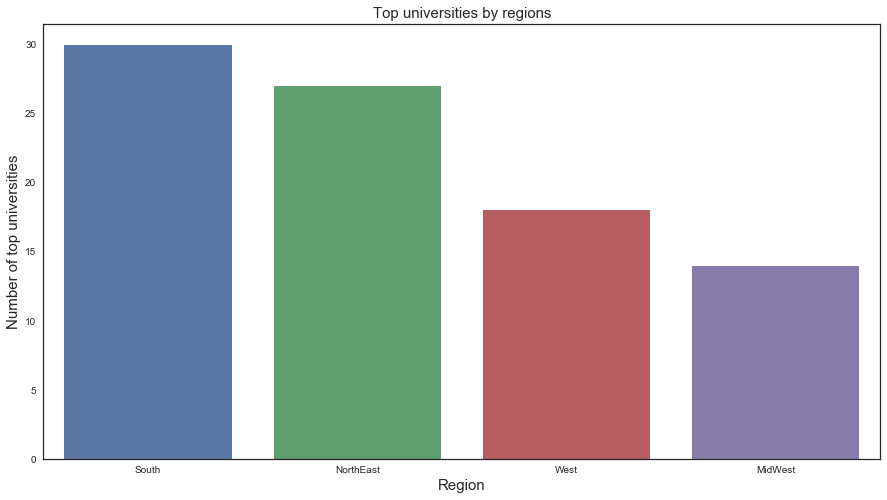

In [269]:
region_wise = university_ranks['Region'].value_counts().to_frame().reset_index()
region_wise.columns = ['Region','universities']
#state_wise.head()
plt.figure(figsize=(15,8))
sns.barplot('Region','universities', data = region_wise)
plt.xlabel('Region',fontsize =15)
plt.ylabel('Number of top universities',fontsize =15)
plt.title('Top universities by regions',fontsize =15)
plt.show()

### Pulling data about crime rates in US cities

In [270]:
crmdf = pd.read_csv('https://query.data.world/s/rrymaubmhlcklztyutmwvdmytcdlxc')
crmdf.head()

,MSA,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Theft,MotorVehicleTheft,State,City
0,"Abilene, TX M.S.A.",412.5,5.3,56.0,78.4,272.8,"3,609.0",852.0,"2,493.6",263.4,TX,Abilene
1,"Akron, OH M.S.A.",238.4,5.1,38.2,75.2,119.8,"2,552.4",575.3,"1,853.0",124.1,OH,Akron
2,"Albany, GA M.S.A.",667.9,7.8,30.4,157.9,471.8,"3,894.1","1,099.6","2,652.8",141.7,GA,Albany
3,"Albany, OR M.S.A.",114.3,2.5,28.2,20.7,63.0,"3,208.4",484.6,"2,476.1",247.7,OR,Albany
4,"Albuquerque, NM M.S.A.",792.6,6.1,63.8,206.7,516.0,"4,607.8",883.4,"3,047.6",676.9,NM,Albuquerque


In [271]:
sum(pd.isnull(crmdf.City))

5

In [272]:
crmdf['City']=crmdf['City'].fillna(crmdf['MSA'].str.split(",").str.get(0))

In [273]:
sum(university_ranks['city'].isin(crmdf.City))

52

In [274]:
crmdf['CrimeTotal']=(crmdf.sum(axis=1,skipna=True))

In [275]:
university_ranks1 = pd.merge(university_ranks,crmdf[['City','State','CrimeTotal']],how = 'inner',left_on =['state','city'],right_on =['State','City'])
university_ranks1.head()

,name,location,rank,world_rank,description,tuition_and_fees,in_state,undergrad_enrollment,city,state,state_full,Region,City,State,CrimeTotal
0,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844.0,Chicago,IL,Illinois,MidWest,Chicago,IL,542.4
1,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844.0,Chicago,IL,Illinois,MidWest,Chicago,IL,614.1
2,University of Pennsylvania,"Philadelphia, PA",8,17,"The University of Pennsylvania, located in Phi...",51464.0,51464,9726.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,605.7
3,University of Pennsylvania,"Philadelphia, PA",8,17,"The University of Pennsylvania, located in Phi...",51464.0,51464,9726.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,1124.5
4,Drexel University,"Philadelphia, PA",96,351-400,Students at Drexel University can get a mix of...,51030.0,51030,14138.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,605.7


## Checking relation between crime rates and number of students enrolling.
### The high crime rate cities have lower enrollment but there isn't any clear pattern showing that location affects ranking indicated by the colormap

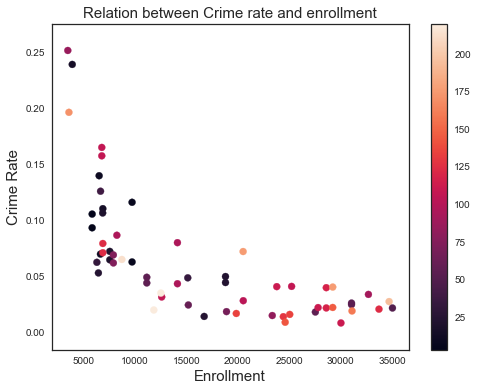

In [276]:
plt.figure(figsize=(8,6))
crime_ranks = plt.scatter(university_ranks1['undergrad_enrollment'],university_ranks1['CrimeTotal']/university_ranks1['undergrad_enrollment'],
                    c=university_ranks1['rank']) #set style options
plt.colorbar(crime_ranks)
plt.xlabel('Enrollment',fontsize = 15)
plt.ylabel('Crime Rate',fontsize = 15)
plt.title('Relation between Crime rate and enrollment',fontsize =15)
plt.show()

## Pulling data on finances of graduating students

In [277]:
student_finance = pd.read_excel('https://query.data.world/s/r75qyy2iaqmwntqupt5agg2z4skvnp')
student_finance.head()

,State,Average Debt,Rank (Avg. Debt),% with Debt,Rank (% w/ debt)
0,Alabama,29153,20,0.52,44
1,Alaska,26171,36,0.55,40
2,Arizona,23780,43,0.56,36
3,Arkansas,26082,38,0.57,34
4,California,22191,48,0.54,42


In [278]:
university_ranks2 = pd.merge(university_ranks1,student_finance[['Average Debt','State','% with Debt']],how = 'inner',left_on =['state_full'],right_on =['State'])

In [295]:
university_ranks2['Average Debt']=university_ranks2['Average Debt'].astype(float)
university_ranks2['% with Debt']=university_ranks2['% with Debt'].astype(float)
university_ranks2.head()

,name,location,rank,world_rank,description,tuition_and_fees,in_state,undergrad_enrollment,city,state,state_full,Region,City,State_x,CrimeTotal,Average Debt,State_y,% with Debt
0,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844.0,Chicago,IL,Illinois,MidWest,Chicago,IL,542.4,29305.0,Illinois,0.66
1,University of Chicago,"Chicago, IL",3,10,"The University of Chicago, situated in Chicago...",52491.0,52491,5844.0,Chicago,IL,Illinois,MidWest,Chicago,IL,614.1,29305.0,Illinois,0.66
2,University of Pennsylvania,"Philadelphia, PA",8,17,"The University of Pennsylvania, located in Phi...",51464.0,51464,9726.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,605.7,34798.0,Pennsylvania,0.71
3,University of Pennsylvania,"Philadelphia, PA",8,17,"The University of Pennsylvania, located in Phi...",51464.0,51464,9726.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,1124.5,34798.0,Pennsylvania,0.71
4,Drexel University,"Philadelphia, PA",96,351-400,Students at Drexel University can get a mix of...,51030.0,51030,14138.0,Philadelphia,PA,Pennsylvania,NorthEast,Philadelphia,PA,605.7,34798.0,Pennsylvania,0.71


## Correlation Heatmap
### The school rank is negatively correlated to the % of the students with debt and the average debt

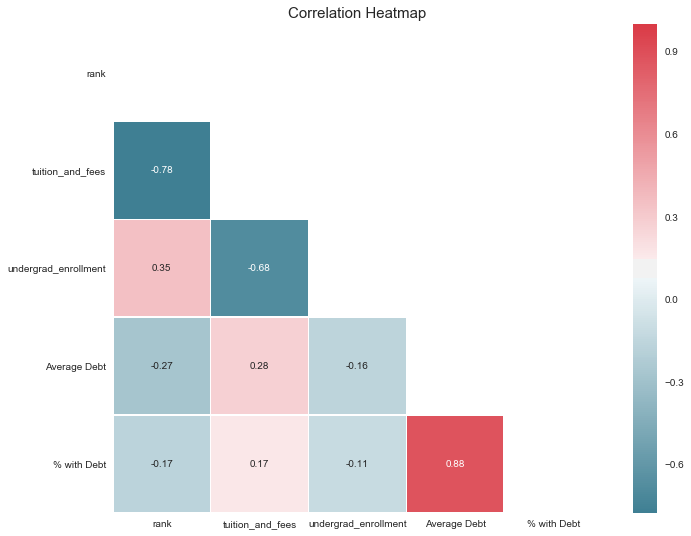

In [280]:

corr = university_ranks2[['rank','tuition_and_fees','undergrad_enrollment','Average Debt','% with Debt']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, annot= True,
            square=True, linewidths=.5, ax=ax)

plt.title('Correlation Heatmap',fontsize =15)
plt.show()